# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
df_raw = pd.read_csv("train.csv")
display(df_raw.head())
df_raw.info()
display(df_raw.describe())

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [6]:
# Missing values
print(df_raw.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [8]:
# Remove rows with missing values
df = df_raw.dropna()
print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (27480, 4)


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [16]:
# Class distribution (sentiment)
print(df['sentiment'].value_counts())

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


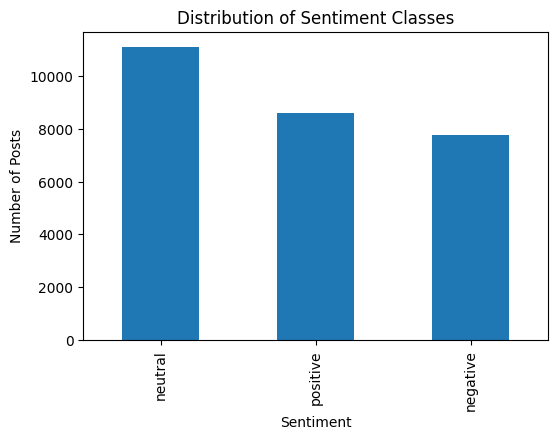

In [12]:
# Plot class distribution
plt.figure(figsize=(6,4))
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.show()

- Найбільше постів нейтрального настрою, що складає ~40% від усіх записів.

- Позитивні та негативні пости менш численні, і приблизно рівні за кількістю.

- Можна сказати, що набір даних має легкий дисбаланс, де нейтральний клас переважає

In [13]:
# Adding a new column with text length in characters
df['text_length'] = df['text'].apply(len)
print(df['text_length'].describe())

count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64


/tmp/ipykernel_108017/1310292366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(len)


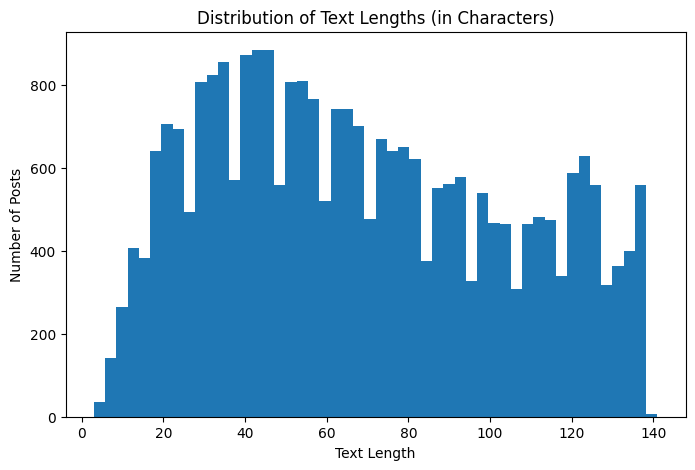

In [14]:
plt.figure(figsize=(8,5))
plt.hist(df['text_length'], bins=50)
plt.title('Distribution of Text Lengths (in Characters)')
plt.xlabel('Text Length')
plt.ylabel('Number of Posts')
plt.show()

- Середня довжина посту ≈ 68 символів, тобто тексти досить короткі.

- Половина постів мають довжину до 64 символів, а четверта частина - менше 39 символів.

- Є дуже короткі пости (3 символи) та довші (до 141 символу).

- Більшість постів є короткими, що можуть ускладнювати правильну класифікацію

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/liubov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
LANG = 'english'  
stop_words = set(stopwords.words(LANG))
stemmer = SnowballStemmer(LANG)

In [22]:
def preprocess_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'[^a-z0-9\s]', ' ', text)  # Remove non-letter characters
    tokens = text.split() # Tokenization
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2] # Remove stopwords and short words
    tokens = [stemmer.stem(word) for word in tokens] # Stemming
    return ' '.join(tokens) # Join tokens back to string

In [23]:
df['clean_text'] = df['text'].astype(str).apply(preprocess_text)

/tmp/ipykernel_108017/2411645621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].astype(str).apply(preprocess_text)


In [24]:
all_words = ' '.join(df['clean_text']).split()
word_counts = Counter(all_words)
print(f"Total unique words: {len(word_counts)}")

Total unique words: 20245


In [27]:
word_counts.most_common(20)

[('day', 2451),
 ('get', 1916),
 ('good', 1600),
 ('work', 1530),
 ('love', 1486),
 ('like', 1462),
 ('http', 1247),
 ('today', 1155),
 ('time', 1104),
 ('go', 1103),
 ('got', 1098),
 ('one', 1076),
 ('lol', 1029),
 ('happi', 1014),
 ('thank', 990),
 ('want', 989),
 ('know', 980),
 ('miss', 968),
 ('back', 920),
 ('realli', 916)]

In [28]:
vocab_size = 5000  
vectorizer = CountVectorizer(max_features=vocab_size)
X = vectorizer.fit_transform(df['clean_text'])
print(f"Bag of Words matrix shape: {X.shape}")

Bag of Words matrix shape: (27480, 5000)


In [29]:
print(vectorizer.get_feature_names_out()[:30])

['000' '100' '1000' '101' '10am' '10pm' '10th' '11am' '11th' '123' '127'
 '12th' '140' '150' '16th' '18th' '1am' '1st' '200' '2000' '2008' '2009'
 '2010' '20min' '22nd' '27th' '2am' '2day' '2moro' '2morrow']


## Що бачимо:

- Багато чисел, годин, дат (10am, 11th, 2008).

- Деякі слова - cкорочення (2day, 2moro, 2morrow).

- Топові частотні слова на кшталт day, get не на першій позиції, бо CountVectorizer сортує словник алфавітно, а не за частотою.

## Інтерпретація:

- Вибір BoW + max_features=5000 включає багато числових/часових токенів, які можуть бути неінформативними для сентименту.

- Можна відфільтрувати токени, що складаються тільки з чисел.

## Для покращення якості моделі:

- Видаляти числа та URL (http) на етапі препроцесингу.

- Можна збільшити vocab_size до 7000–8000, щоб включити більше значущих слів.

Після цього повторно навчити модель і подивитися на точність

In [56]:
def preprocess_text_v2(text):
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

df['clean_text_v2'] = df['text'].astype(str).apply(preprocess_text_v2)

/tmp/ipykernel_108017/4124526442.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text_v2'] = df['text'].astype(str).apply(preprocess_text_v2)


In [57]:
df['clean_text_v2']

0                                               respond go
1                                  sooo sad miss san diego
2                                               boss bulli
3                                      interview leav alon
4                            son put releas alreadi bought
                               ...                        
27476    wish could come see denver husband lost job af...
27477    wonder rake client made clear net forc dev lea...
27478    yay good enjoy break probabl need hectic weeke...
27479                                                worth
27480                           flirt go atg smile yay hug
Name: clean_text_v2, Length: 27480, dtype: object

In [58]:
vocab_size = 7000
vectorizer_v2 = CountVectorizer(max_features=vocab_size)
X_v2 = vectorizer_v2.fit_transform(df['clean_text_v2'])

print(f"Bag of Words matrix shape (updated): {X_v2.shape}")

Bag of Words matrix shape (updated): (27480, 7000)


In [59]:
all_words_v2 = ' '.join(df['clean_text_v2']).split()
word_counts_v2 = Counter(all_words_v2)

top_20_words = word_counts_v2.most_common(20)
print("Top 20 most frequent words (updated BoW):")
for word, count in top_20_words:
    print(f"{word}: {count}")

Top 20 most frequent words (updated BoW):
day: 2497
get: 1917
good: 1600
work: 1530
love: 1486
like: 1462
today: 1155
time: 1104
go: 1103
got: 1099
one: 1077
lol: 1029
happi: 1014
want: 991
thank: 991
know: 980
miss: 967
back: 920
realli: 916
see: 905


In [60]:
vectorizer_v2.get_feature_names_out()[:30]

array(['aaaa', 'aaaah', 'aaah', 'aaahhh', 'aaaw', 'aaawww', 'aah',
       'aargh', 'aaron', 'abandon', 'abbey', 'abbi', 'abbrevi', 'abc',
       'abi', 'abid', 'abil', 'abit', 'abl', 'aboard', 'abram', 'abroad',
       'absent', 'absolut', 'absolutley', 'abt', 'abus', 'abuzz',
       'academ', 'academi'], dtype=object)

- Схоже, що видалення чисел та URL спрацювало: тепер словник не засмічений технічними токенами.

- Топ-слова краще відображають емоційний контент, що має позитивно вплинути на якість моделі.

- Збільшення vocab_size до 7000 дозволило включити більше значущих слів, не збільшуючи розмір матриці надмірно.

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [31]:
y = df['sentiment']
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training: {X_train_bow.shape}")
print(f"Test: {X_test_bow.shape}")

Training: (21984, 5000)
Test: (5496, 5000)


In [39]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_bow, y_train)
y_pred_lr = lr.predict(X_test_bow)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", acc_lr)

Logistic Regression Accuracy: 0.6917758369723436


In [40]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_bow, y_train)
y_pred_dt = dt.predict(X_test_bow)
acc_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", acc_dt)

Decision Tree Accuracy: 0.6433770014556041


In [41]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_bow, y_train)
y_pred_rf = rf.predict(X_test_bow)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)

Random Forest Accuracy: 0.6901382823871907


In [61]:
# Logistic Regression_v2

# Використаємо той самий розподіл train/test, що і раніше
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2, df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment']
)

lr_v2 = LogisticRegression(max_iter=1000)
lr_v2.fit(X_train_v2, y_train_v2)

y_pred_v2 = lr_v2.predict(X_test_v2)

acc_v2 = accuracy_score(y_test_v2, y_pred_v2)
print(f"Logistic Regression Accuracy (updated BoW): {acc_v2:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_v2, y_pred_v2))


Logistic Regression Accuracy (updated BoW): 0.6925

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.63      0.67      1556
     neutral       0.64      0.72      0.68      2223
    positive       0.77      0.71      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.69      0.69      5496
weighted avg       0.70      0.69      0.69      5496



In [62]:
coefficients = lr_v2.coef_[0]  
feature_names = vectorizer_v2.get_feature_names_out()

coef_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
})
coef_df['abs_coeff'] = coef_df['coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coeff', ascending=False)

print("Top 20 influential words (updated BoW):")
display(coef_df_sorted.head(20))


Top 20 influential words (updated BoW):


,word,coefficient,abs_coeff
5222,sad,2.655755,2.655755
5915,suck,2.518267,2.518267
5692,sorri,2.454184,2.454184
749,bore,2.427505,2.427505
2443,glad,-2.411635,2.411635
391,awesom,-2.372374,2.372374
2683,hate,2.321350,2.321350
2074,fail,2.130368,2.130368
3664,love,-2.108650,2.108650
3910,miss,2.096323,2.096323


- Accuracy: 0.6925 — трохи покращилась порівняно з попередньою BoW (~0.691).

- F1-score по класах: Negative: 0.67, Neutral: 0.68, Positive: 0.74

## Висновок:

- Оновлений словник допоміг пом’якшити вплив нейтральних частих слів і виділити більш значущі токени для сентименту.

- Найкраще модель визначає позитивні пости (F1 = 0.74).

- Нейтральні та негативні пости трохи плутаються, але загальна точність покращилась.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [43]:
# Get the coefficients from Logistic Regression
coefficients = lr.coef_[0]  # Assuming binary sentiment
feature_names = vectorizer.get_feature_names_out()

coef_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
})

coef_df['abs_coeff'] = coef_df['coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coeff', ascending=False)

display(coef_df_sorted.head(20))

,word,coefficient,abs_coeff
3704,sad,2.656722,2.656722
4236,suck,2.492949,2.492949
4044,sorri,2.455306,2.455306
569,bore,2.377387,2.377387
1886,glad,-2.375369,2.375369
2080,hate,2.348390,2.348390
360,awesom,-2.346378,2.346378
1591,fail,2.143252,2.143252
4225,stupid,2.124928,2.124928
2688,love,-2.117210,2.117210


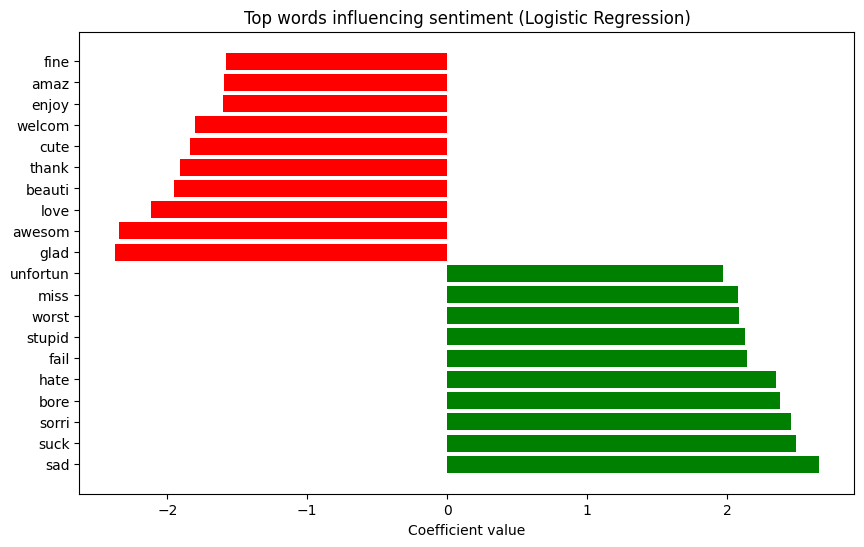

In [44]:
top_pos = coef_df_sorted.sort_values(by='coefficient', ascending=False).head(10)
top_neg = coef_df_sorted.sort_values(by='coefficient').head(10)

plt.figure(figsize=(10,6))
plt.barh(top_pos['word'], top_pos['coefficient'], color='green')
plt.barh(top_neg['word'], top_neg['coefficient'], color='red')
plt.title("Top words influencing sentiment (Logistic Regression)")
plt.xlabel("Coefficient value")
plt.show()

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [46]:
vocab_size = 5000  

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=vocab_size,
    lowercase=True,
    preprocessor=None,  # we've already preprocessed
    tokenizer=lambda x: x.split()  # text is already tokenized + stemmed
)

# Fit and transform the cleaned text
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

TF-IDF matrix shape: (27480, 5000)


/home/liubov/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [47]:
from scipy.sparse import csr_matrix
X_train_tfidf = X_tfidf[X_train_bow.indices.min():X_train_bow.indices.max()+1]  # optional

train_mask = np.zeros(df.shape[0], dtype=bool)
train_mask[X_train_bow.indices] = True
X_train_tfidf = X_tfidf[train_mask]
X_test_tfidf = X_tfidf[~train_mask]

y_train_tfidf = y_train
y_test_tfidf = y_test

In [48]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
# Train Logistic Regression
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

In [50]:
acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
print(f"Logistic Regression Accuracy (TF-IDF): {acc_tfidf:.4f}")

print("Classification Report (TF-IDF):")
print(classification_report(y_test_tfidf, y_pred_tfidf))

Logistic Regression Accuracy (TF-IDF): 0.6870
Classification Report (TF-IDF):
              precision    recall  f1-score   support

    negative       0.72      0.60      0.66      1556
     neutral       0.62      0.75      0.68      2223
    positive       0.78      0.69      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.71      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496



In [51]:
coefficients_tfidf = lr_tfidf.coef_[0]
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

coef_tfidf_df = pd.DataFrame({
    'word': feature_names_tfidf,
    'coefficient': coefficients_tfidf
})

coef_tfidf_df['abs_coeff'] = coef_tfidf_df['coefficient'].abs()
coef_tfidf_sorted = coef_tfidf_df.sort_values(by='abs_coeff', ascending=False)

print("Top 20 words influencing sentiment (TF-IDF):")
display(coef_tfidf_sorted.head(20))

Top 20 words influencing sentiment (TF-IDF):


,word,coefficient,abs_coeff
3704,sad,5.196486,5.196486
2688,love,-4.986935,4.986935
2865,miss,4.738728,4.738728
4044,sorri,4.597488,4.597488
2080,hate,4.408586,4.408586
4236,suck,4.274325,4.274325
569,bore,3.895268,3.895268
4377,thank,-3.773699,3.773699
1591,fail,3.716486,3.716486
2264,hurt,3.501002,3.501002


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

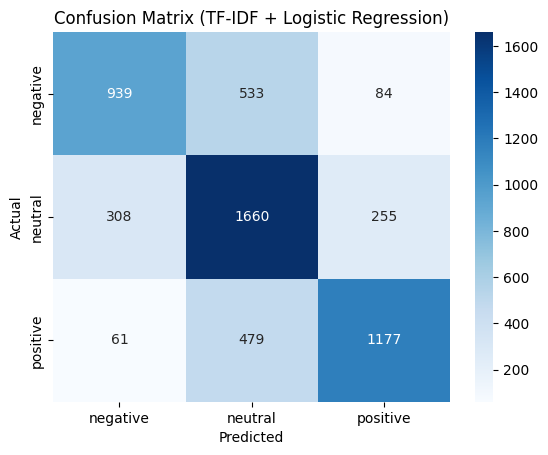

In [53]:
cm = confusion_matrix(y_test_tfidf, y_pred_tfidf, labels=['negative','neutral','positive'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (TF-IDF + Logistic Regression)')
plt.show()

Нейтральні пости іноді плутаються з позитивними або негативними, оскільки містять деякі слова з емоційним забарвленням.

Короткі пости (1–3 слова) часто класифікуються неправильно, бо TF-IDF не має достатнього контексту для визначення сентименту.

## Пропоновані шляхи покращення класифікації

1. Більш просунута попередня обробка тексту / використання ембедингів

2. Використання n-грам у TF-IDF

3. Врахування дисбалансу класів або використання ансамблевих моделей

Якщо деякі класи (наприклад, нейтральний) переважають, можна зважувати класи у Logistic Regression або використовувати ансамблеві моделі (Random Forest, Gradient Boosting) для покращення F1-score.

Можна також поєднати TF-IDF з метаданими, наприклад довжина посту, кількість емодзі, пунктуації, щоб отримати додаткові сигнали.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model